In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"axes.axisbelow": True})
from scipy.stats import ks_2samp

In [2]:
news_citations_df = pd.read_parquet(
    "../data/intermediate/citation_analysis/news_citations.parquet"
)

In [4]:
len(news_citations_df)

32865

In [3]:
news_citations_df_leaning = news_citations_df[
    news_citations_df.political_leaning_score.notna()
]

In [5]:
len(news_citations_df_leaning)

32405

In [6]:
provider_colors = {
    "gpt": "#2E3440",
    "gemini": "#B66A97",
    "perplexity": "#20808D",
}

provider_names = {
    "gpt": "OpenAI",
    "perplexity": "Perplexity",
    "gemini": "Google",
}

providers = ["gpt", "perplexity", "gemini"]

In [24]:
family_data = news_citations_df_leaning[
    news_citations_df_leaning["model_family"] == "perplexity"
]

In [25]:
len(family_data.query("political_leaning_score > 0.33")) / len(family_data)

0.01194014553653787

In [12]:
dict(family_data.political_leaning.value_counts(normalize=True))

{'center_leaning': np.float64(0.8520866349709456),
 'left_leaning': np.float64(0.14474379292128897),
 'right_leaning': np.float64(0.003169572107765452)}

In [16]:
# Print summary statistics
print("Leaning Score Distribution Summary:")
print("=" * 50)
leaning_pct = {}
for family in providers:
    family_data = news_citations_df_leaning[
        news_citations_df_leaning["model_family"] == family
    ]
    mean_score = family_data["political_leaning_score"].mean()
    median_score = family_data["political_leaning_score"].median()
    std_score = family_data["political_leaning_score"].std()
    leaning_pct[family] = dict(
        family_data.political_leaning.value_counts(normalize=True)
    )
    total = len(family_data)

    print(f"{family.upper()}:")
    print(f"  Citations with leaning scores: {total:,}")
    print(f"  Mean leaning score: {mean_score:.3f}")
    print(f"  Median leaning score: {median_score:.3f}")
    print(f"  Std deviation: {std_score:.3f}")
    for leaning in ["left_leaning", "center_leaning", "right_leaning"]:
        print(leaning, f"{leaning_pct[family][leaning] * 100:.1f}%")

Leaning Score Distribution Summary:
GPT:
  Citations with leaning scores: 7,572
  Mean leaning score: -0.237
  Median leaning score: -0.224
  Std deviation: 0.129
left_leaning 14.5%
center_leaning 85.2%
right_leaning 0.3%
PERPLEXITY:
  Citations with leaning scores: 19,514
  Mean leaning score: -0.215
  Median leaning score: -0.217
  Std deviation: 0.192
left_leaning 23.6%
center_leaning 75.2%
right_leaning 1.2%
GEMINI:
  Citations with leaning scores: 5,319
  Mean leaning score: -0.225
  Median leaning score: -0.209
  Std deviation: 0.181
left_leaning 26.3%
center_leaning 72.8%
right_leaning 0.8%


In [17]:
for family_1 in providers:
    for family_2 in providers:
        if family_1 != family_2:
            family_1_data = news_citations_df_leaning[
                news_citations_df_leaning["model_family"] == family_1
            ]
            family_2_data = news_citations_df_leaning[
                news_citations_df_leaning["model_family"] == family_2
            ]
            stats, p = ks_2samp(
                family_1_data.political_leaning_score,
                family_2_data.political_leaning_score,
            )
            print(family_1, family_2, stats, p)

gpt perplexity 0.26117961498756814 0.0
gpt gemini 0.3021278114012232 3.45358974045737e-252
perplexity gpt 0.26117961498756814 0.0
perplexity gemini 0.0523077101831701 2.2202491788314795e-10
gemini gpt 0.3021278114012232 3.45358974045737e-252
gemini perplexity 0.0523077101831701 2.2202491788314795e-10


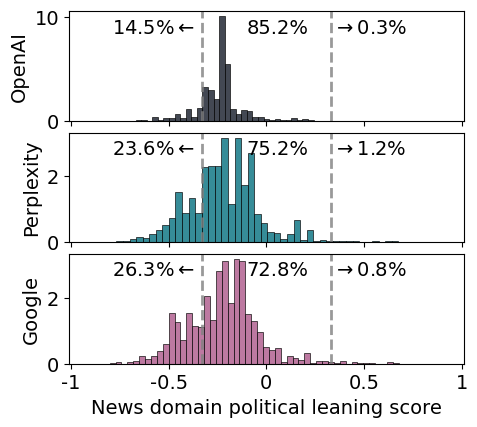

In [46]:
# Create figure with subfigures for quality score distribution by model family
fig = plt.figure(figsize=(5, 4.5))

for i, family in enumerate(providers):
    plt.subplot(3, 1, i + 1)
    # Filter data for this family with non-null quality scores
    family_data = news_citations_df_leaning[
        news_citations_df_leaning["model_family"] == family
    ]

    # Create histogram
    plt.hist(
        family_data["political_leaning_score"],
        bins=50,
        alpha=0.9,
        color=provider_colors[family],
        edgecolor="black",
        linewidth=0.5,
        density=True,
    )

    # Add vertical line at 0.5
    plt.axvline(x=-0.33, color="gray", linestyle="--", linewidth=2, alpha=0.8)
    plt.axvline(x=0.33, color="gray", linestyle="--", linewidth=2, alpha=0.8)
    xs = [-1, -0.5, 0, 0.5, 1]
    if i == 2:
        plt.xlabel("News domain political leaning score")

        plt.xticks(xs, xs)
    else:
        plt.xticks(xs, [])
    plt.ylabel(provider_names[family])
    plt.xlim([-1.01, 1.01])

    plt.text(
        0.11,
        0.8,
        f"{leaning_pct[family]['left_leaning'] * 100:.1f}%$\\leftarrow$",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.45,
        0.8,
        f"{leaning_pct[family]['center_leaning'] * 100:.1f}%",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.67,
        0.8,
        f"$\\rightarrow${leaning_pct[family]['right_leaning'] * 100:.1f}%",
        transform=plt.gca().transAxes,
    )
plt.tight_layout(h_pad=0)
plt.savefig("../data/output/citation_analysis/model_family_leaning_distribution.pdf")